In [1]:
import numpy as np
import skimage.data
import skimage.io as io
import matplotlib.pyplot as plt

In [2]:
### reference1: https://github.com/ahmedfgad/NumPyCNN/tree/master
### reference2: https://www.kdnuggets.com/2018/04/building-convolutional-neural-network-numpy-scratch.html

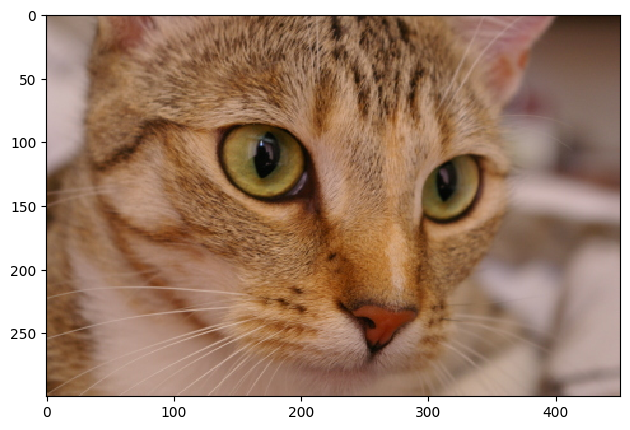

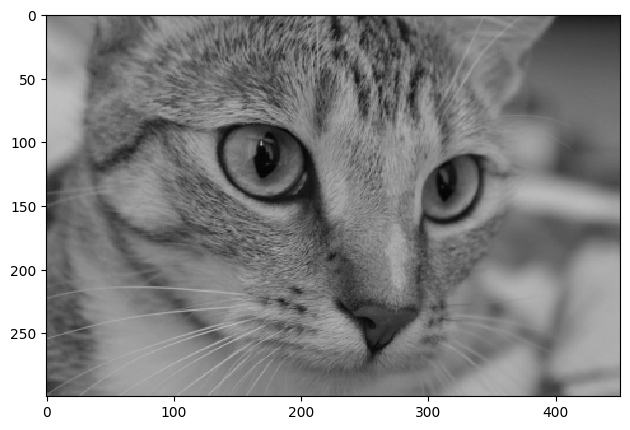

In [3]:
# Reading the image (rgb) 
img = skimage.data.chelsea()  
# show image
io.imshow(img)   
io.show()

# Converting the image into gray.  
img = skimage.color.rgb2gray(img)
# show grey img
io.imshow(img) 
io.show()

## preparing filters

In [4]:
# filters of the first conv layer
l1_filter = np.zeros((2,3,3))

l1_filter[0, :, :] = np.array([[[-1, 0, 1],   
                                   [-1, 0, 1],   
                                   [-1, 0, 1]]])  
l1_filter[1, :, :] = np.array([[[1,   1,  1],   
                                   [0,   0,  0],   
                                   [-1, -1, -1]]]) 

## Conv layer

In [5]:
def conv_(img, conv_filter):  
    filter_size = conv_filter.shape[0]   ## 2x3x3
    result = np.zeros((img.shape))   ## output shape
    
    #Looping through the image to apply the convolution operation.  
    for r in np.uint16(np.arange(filter_size/2,   
                          img.shape[0]-filter_size/2-2)):  
        for c in np.uint16(np.arange(filter_size/2, img.shape[1]-filter_size/2-2)):  
            #Getting the current region to get multiplied with the filter.  
            curr_region = img[r:r+filter_size, c:c+filter_size]  
            #Element-wise multipliplication between the current region and the filter.  
            curr_result = curr_region * conv_filter  
            conv_sum = np.sum(curr_result) #Summing the result of multiplication.  
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.  
             
    #Clipping the outliers of the result matrix.  
    final_result = result[np.uint16(filter_size/2):result.shape[0]-np.uint16(filter_size/2),   
                          np.uint16(filter_size/2):result.shape[1]-np.uint16(filter_size/2)]  
    return final_result  

In [6]:
def conv(img, conv_filter):  
    # Check if number of image channels matches the filter depth.
    if len(img.shape) > 2 or len(conv_filter.shape) > 3:   
         if img.shape[-1] != conv_filter.shape[-1]:  
            print("Error: Number of channels in both image and filter must match.")  
            sys.exit() 
            
    # Check if filter dimensions are equal.        
    if conv_filter.shape[1] != conv_filter.shape[2]:   
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')  
        sys.exit()  
        
        
    # Check if filter diemnsions are odd.     
    if conv_filter.shape[1]%2==0:  
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')  
        sys.exit()  
  
    # An empty feature map to hold the output of convolving the filter(s) with the image.  
    feature_maps = np.zeros((img.shape[0]-conv_filter.shape[1]+1,   
                                img.shape[1]-conv_filter.shape[1]+1,   
                                conv_filter.shape[0]))  
  
    # Convolving the image by the filter(s).  
    for filter_num in range(conv_filter.shape[0]):  
        print("Filter ", filter_num + 1)  
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.  
        """  
        Checking if there are mutliple channels for the single filter. 
        If so, then each channel will convolve the image. 
        The result of all convolutions are summed to return a single feature map. 
        """  
        if len(curr_filter.shape) > 2:  
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.  
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.  
                conv_map = conv_map + conv_(img[:, :, ch_num],   
                                  curr_filter[:, :, ch_num])  
        else: # There is just a single channel in the filter.  
            conv_map = conv_(img, curr_filter)  
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps. 

In [7]:
## output of the first conv layer
l1_feature_map = conv(img, l1_filter)

Filter  1
Filter  2


In [8]:
l1_feature_map.shape

(298, 449, 2)

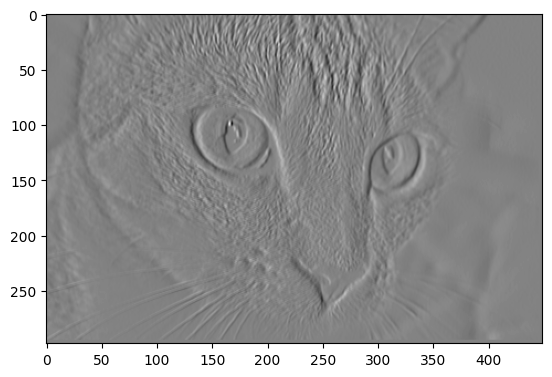

In [9]:
# io.imshow(l1_feature_map[:,:,0],cmap="gray")
# io.show()

# io.imshow(l1_feature_map[:,:,1],cmap="gray")
# io.show()

plt.imshow(l1_feature_map[:,:,0]).set_cmap("gray")


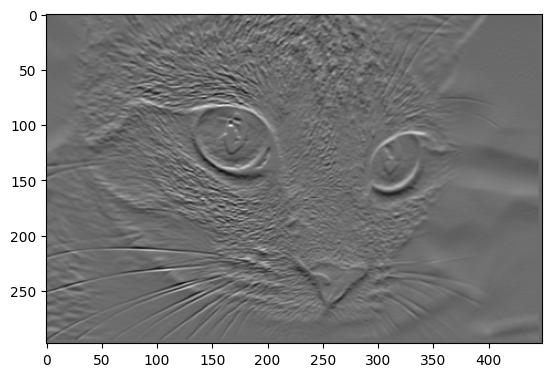

In [10]:
plt.imshow(l1_feature_map[:,:,1]).set_cmap("gray")

## ReLU layer

In [11]:
def relu(feature_map):  
    #Preparing the output of the ReLU activation function.  
    relu_out = np.zeros(feature_map.shape)  
    for map_num in range(feature_map.shape[-1]):  
        for r in np.arange(0,feature_map.shape[0]):  
            for c in np.arange(0, feature_map.shape[1]):  
                relu_out[r, c, map_num] = np.max(feature_map[r, c, map_num], 0)  
                
    return relu_out

In [12]:
## output after relu
l1_feature_map_relu = relu(l1_feature_map)
l1_feature_map_relu.shape

(298, 449, 2)

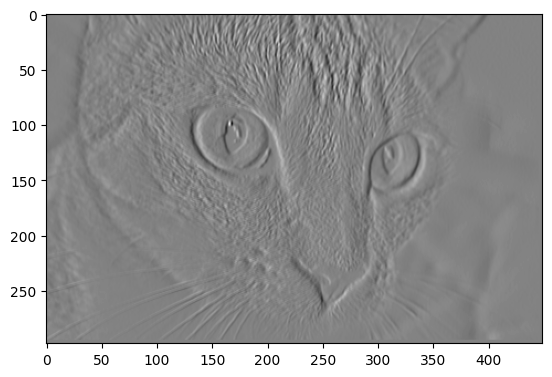

In [13]:
# io.imshow(l1_feature_map_relu[:,:,0],cmap="gray")
# io.show()

# io.imshow(l1_feature_map_relu[:,:,1],cmap="gray")
# io.show()

plt.imshow(l1_feature_map_relu[:,:,0]).set_cmap("gray")

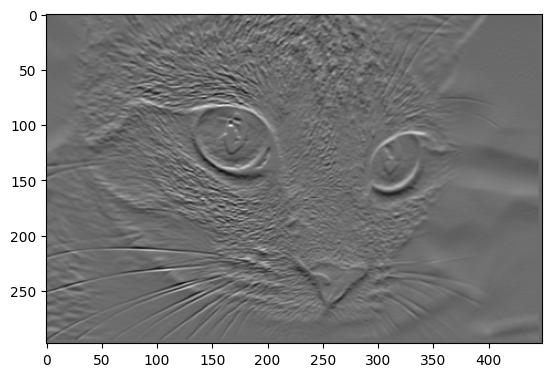

In [14]:
plt.imshow(l1_feature_map_relu[:,:,1]).set_cmap("gray")

## Max pooling

In [15]:
## pooling layer
def pooling(feature_map, size=2, stride=2):  
    #Preparing the output of the pooling operation.  
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride),  
                            np.uint16((feature_map.shape[1]-size+1)/stride),  
                            feature_map.shape[-1]))  
    for map_num in range(feature_map.shape[-1]):  
        r2 = 0  
        for r in np.arange(0,feature_map.shape[0]-size-1, stride):  
            c2 = 0  
            for c in np.arange(0, feature_map.shape[1]-size-1, stride):  
                pool_out[r2, c2, map_num] = np.max(feature_map[r:r+size,  c:c+size])  
                c2 = c2 + 1  
            r2 = r2 +1  
            
    return pool_out

In [16]:
## output after pooling layer
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)  

l1_feature_map_relu_pool.shape

(148, 224, 2)

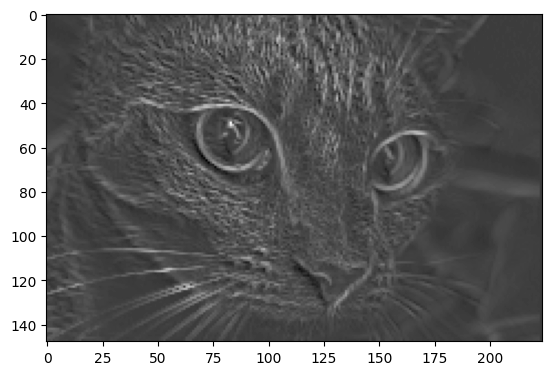

In [17]:
# io.imshow(l1_feature_map_relu_pool[:,:,0],cmap="gray")
# io.show()

# io.imshow(l1_feature_map_relu_pool[:,:,1],cmap="gray")
# io.show()

plt.imshow(l1_feature_map_relu_pool[:,:,0]).set_cmap("gray")

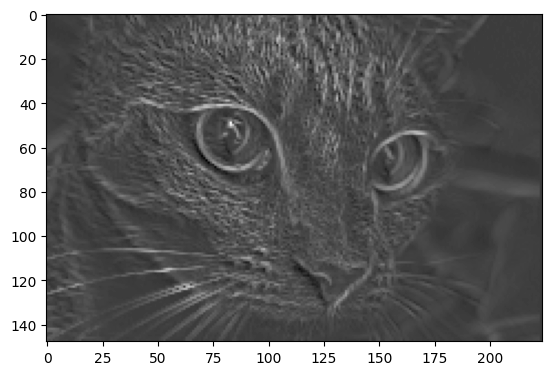

In [18]:
plt.imshow(l1_feature_map_relu_pool[:,:,1]).set_cmap("gray")

## Stacking layers

In [19]:
# Second conv layer  
l2_filter = np.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])  
print("\n**Working with conv layer 2**")  
l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)  
print("\n**ReLU**")  
l2_feature_map_relu = relu(l2_feature_map)  
print("\n**Pooling**")  
l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)  
print("**End of conv layer 2**\n") 


**Working with conv layer 2**
Filter  1
Filter  2
Filter  3

**ReLU**

**Pooling**
**End of conv layer 2**



Text(0.5, 1.0, 'l2_fm_relu_pool2')

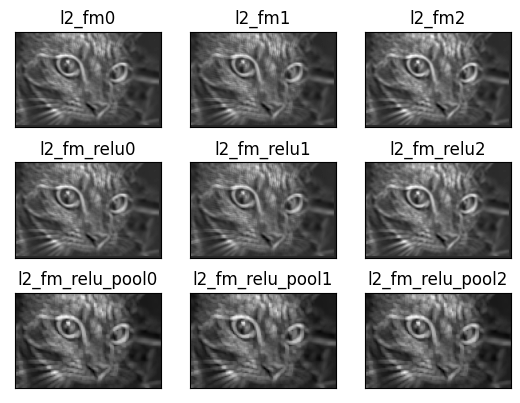

In [23]:
# plot output of the second conv layer
fig2, ax2 = plt.subplots(nrows=3, ncols=3)
    
    
ax2[0, 0].imshow(l2_feature_map[:, :, 0]).set_cmap("gray")
# remove the x and y ticks
ax2[0, 0].set_xticks([])
ax2[0, 0].set_yticks([])
ax2[0, 0].set_title("l2_fm0")

ax2[0, 1].imshow(l2_feature_map[:, :, 1]).set_cmap("gray")
# remove the x and y ticks
ax2[0, 1].set_xticks([])
ax2[0, 1].set_yticks([])
ax2[0, 1].set_title("l2_fm1")

ax2[0, 2].imshow(l2_feature_map[:, :, 2]).set_cmap("gray")
# remove the x and y ticks
ax2[0, 2].set_xticks([])
ax2[0, 2].set_yticks([])
ax2[0, 2].set_title("l2_fm2")

ax2[1, 0].imshow(l2_feature_map_relu[:, :, 0]).set_cmap("gray")
# remove the x and y ticks
ax2[1, 0].set_xticks([])
ax2[1, 0].set_yticks([])
ax2[1, 0].set_title("l2_fm_relu0")

ax2[1, 1].imshow(l2_feature_map_relu[:, :, 1]).set_cmap("gray")
# remove the x and y ticks
ax2[1, 1].set_xticks([])
ax2[1, 1].set_yticks([])
ax2[1, 1].set_title("l2_fm_relu1")

ax2[1, 2].imshow(l2_feature_map_relu[:, :, 2]).set_cmap("gray")
# remove the x and y ticks
ax2[1, 2].set_xticks([])
ax2[1, 2].set_yticks([])
ax2[1, 2].set_title("l2_fm_relu2")

ax2[2, 0].imshow(l2_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
# remove the x and y ticks
ax2[2, 0].set_xticks([])
ax2[2, 0].set_yticks([])
ax2[2, 0].set_title("l2_fm_relu_pool0")

ax2[2, 1].imshow(l2_feature_map_relu_pool[:, :, 1]).set_cmap("gray")
# remove the x and y ticks
ax2[2, 1].set_xticks([])
ax2[2, 1].set_yticks([])
ax2[2, 1].set_title("l2_fm_relu_pool1")

ax2[2, 2].imshow(l2_feature_map_relu_pool[:, :, 2]).set_cmap("gray")
# remove the x and y ticks
ax2[2, 2].set_xticks([])
ax2[2, 2].set_yticks([])
ax2[2, 2].set_title("l2_fm_relu_pool2")

#matplotlib.pyplot.savefig("L2.png", bbox_inches="tight")
#matplotlib.pyplot.close(fig2)

In [24]:
# Third conv layer  
l3_filter = np.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])  
print("\n**Working with conv layer 3**")  
l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)  
print("\n**ReLU**")  
l3_feature_map_relu = relu(l3_feature_map)  
print("\n**Pooling**")  
l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)  
print("**End of conv layer 3**\n")  


**Working with conv layer 3**
Filter  1

**ReLU**

**Pooling**
**End of conv layer 3**



Text(0.5, 1.0, 'l3_fm_relu_pool')

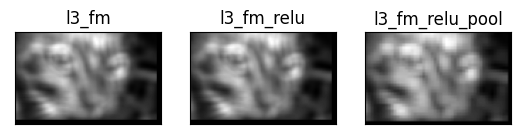

In [25]:
# plot the third conv layer
fig3, ax3 = plt.subplots(nrows=1, ncols=3)
ax3[0].imshow(l3_feature_map[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("l3_fm")

ax3[1].imshow(l3_feature_map_relu[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("l3_fm_relu")

ax3[2].imshow(l3_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("l3_fm_relu_pool")

Text(0.5, 1.0, 'l1_fm_relu_pool1')

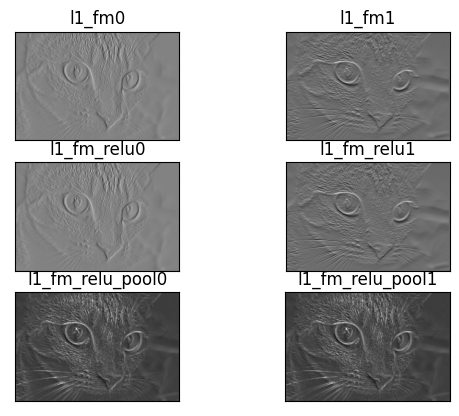

In [26]:
# Plot output of the first conv layer.
fig1, ax1 = plt.subplots(nrows=3, ncols=2)
ax1[0, 0].imshow(l1_feature_map[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("l1_fm0")

ax1[0, 1].imshow(l1_feature_map[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("l1_fm1")

ax1[1, 0].imshow(l1_feature_map_relu[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("l1_fm_relu0")

ax1[1, 1].imshow(l1_feature_map_relu[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("l1_fm_relu1")

ax1[2, 0].imshow(l1_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("l1_fm_relu_pool0")

ax1[2, 1].imshow(l1_feature_map_relu_pool[:, :, 1]).set_cmap("gray")
ax1[2, 1].get_xaxis().set_ticks([])
ax1[2, 1].get_yaxis().set_ticks([])
ax1[2, 1].set_title("l1_fm_relu_pool1")
